In [0]:
import pickle
import pandas as pd
with open('data', 'rb') as f:
  data = pickle.load(f)

In [0]:
data.head(2)

,English,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...


In [0]:
# Vocabulary of English
all_eng_words=[]
for eng in data.English:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.append(word)

# Vocabulary of French 
all_french_words=[]
for mar in data.french:
    for word in mar.split():
        if word not in all_french_words:
            all_french_words.append(word)

In [0]:
all_eng_words = list(set(all_eng_words))

In [0]:
all_french_words = list(set(all_french_words))

In [0]:
# import numpy as np
# lenght_list=[]
# for l in data.English:
#     lenght_list.append(len(l.split(' ')))
# max_length_src = np.max(lenght_list)
# max_length_src

17

In [0]:
# lenght_list=[]
# for l in data.french:
#     lenght_list.append(len(l.split(' ')))
# max_length_tar = np.max(lenght_list)
# max_length_tar

23

In [0]:

#All input words
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))

# get the length of the vocabalary // Kitne words // this will help while performing embedding layer
num_encoder_tokens = len(all_eng_words) + 1
num_decoder_tokens = len(all_french_words) + 1

num_encoder_tokens, num_decoder_tokens

(228, 356)

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
#Tokenizing the source sentences
input_token_index


#Tokenizing the target sentences French
target_token_index

In [0]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,English,french
58525,"france is usually wet during winter , but it i...",la france est généralement humide pendant l' h...
3660,"india is nice during september , and it is usu...","l' inde est agréable en septembre , et il gèle..."
6803,"california is pleasant during september , but ...","californie est agréable au mois de septembre ,..."
101484,the united states is usually snowy during apri...,les états-unis est généralement enneigée en av...
21080,"she likes bananas , grapes , and apples .","elle aime les bananes , les raisins et les pom..."


In [0]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y = data.English, data.french
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((124074,), (13786,))

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=1000):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j
                    + batch_size], y[j:j + batch_size])):

                # for words in each sentence //English
                for (t, word) in enumerate(input_text.split()):  # English wale text ko tokenize kiya gaya
                    encoder_input_data[i] = input_token_index[word]  # encoder input seq

                # for each word in French Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()):
                        decoder_input_data[i] = target_token_index[word]  # decoder input seq
                    if t > 0:
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t - 1,
                                target_token_index[word]] = 1.
                                                       
            yield ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [0]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
# Encoder
latent_dim = 64 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null

# **num_encoder_tokens** vocabulary size we are having
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs) #Embedding layer # this layer will make it 3D

#training the LSTM on encoder
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) #output

encoder_states = [state_h, state_c] #output and the cell state

In [0]:

#  Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True) 
dec_emb = dec_emb_layer(decoder_inputs) # french sikhaye hum model ko


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 64)     14336       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 64)     22592       input_8[0][0]                    
____________________________________________________________________________________________

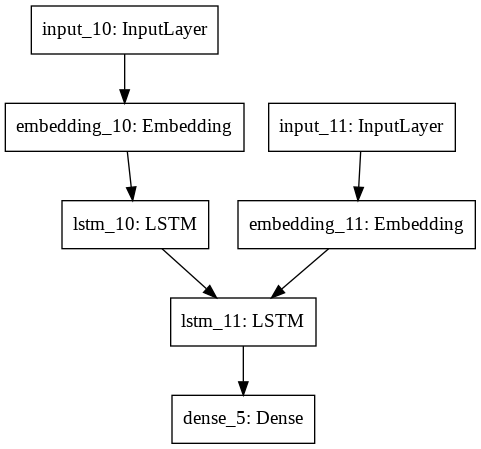

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [0]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = 10000),
                    steps_per_epoch = 50000, # batch size
                    epochs=1,
                    validation_data = generate_batch(X_test, y_test, batch_size = 10000),
                    validation_steps = 50000 # batch size
                    )

Epoch 1/1
